In [3]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import pandas as pd

In [4]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext
sc= SparkContext()
sqlContext = SQLContext(sc)

CV_data = sqlContext.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load('churn-bigml-80.csv')

In [5]:
test_data = sqlContext.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load('churn-bigml-20.csv')

In [6]:
CV_data.cache()
CV_data.printSchema()

root
 |-- State: string (nullable = true)
 |-- Account length: integer (nullable = true)
 |-- Area code: integer (nullable = true)
 |-- International plan: string (nullable = true)
 |-- Voice mail plan: string (nullable = true)
 |-- Number vmail messages: integer (nullable = true)
 |-- Total day minutes: double (nullable = true)
 |-- Total day calls: integer (nullable = true)
 |-- Total day charge: double (nullable = true)
 |-- Total eve minutes: double (nullable = true)
 |-- Total eve calls: integer (nullable = true)
 |-- Total eve charge: double (nullable = true)
 |-- Total night minutes: double (nullable = true)
 |-- Total night calls: integer (nullable = true)
 |-- Total night charge: double (nullable = true)
 |-- Total intl minutes: double (nullable = true)
 |-- Total intl calls: integer (nullable = true)
 |-- Total intl charge: double (nullable = true)
 |-- Customer service calls: integer (nullable = true)
 |-- Churn: boolean (nullable = true)



In [7]:
pd.DataFrame(CV_data.take(5), columns = CV_data.columns).transpose()

,0,1,2,3,4
State,KS,OH,NJ,OH,OK
Account length,128,107,137,84,75
Area code,415,415,415,408,415
International plan,No,No,No,Yes,Yes
Voice mail plan,Yes,Yes,No,No,No
Number vmail messages,25,26,0,0,0
Total day minutes,265.1,161.6,243.4,299.4,166.7
Total day calls,110,123,114,71,113
Total day charge,45.07,27.47,41.38,50.9,28.34
Total eve minutes,197.4,195.5,121.2,61.9,148.3


In [8]:
CV_data.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
State,2666,None,None,AK,WY
Account length,2666,100.62040510127532,39.56397365334985,1,243
Area code,2666,437.43885971492875,42.521018019427174,408,510
International plan,2666,None,None,No,Yes
Voice mail plan,2666,None,None,No,Yes
Number vmail messages,2666,8.021755438859715,13.61227701829193,0,50
Total day minutes,2666,179.48162040510135,54.21035022086982,0.0,350.8
Total day calls,2666,100.31020255063765,19.988162186059512,0,160
Total day charge,2666,30.512404351087813,9.215732907163497,0.0,59.64


In [9]:
CV_data.dtypes

[('State', 'string'),
 ('Account length', 'int'),
 ('Area code', 'int'),
 ('International plan', 'string'),
 ('Voice mail plan', 'string'),
 ('Number vmail messages', 'int'),
 ('Total day minutes', 'double'),
 ('Total day calls', 'int'),
 ('Total day charge', 'double'),
 ('Total eve minutes', 'double'),
 ('Total eve calls', 'int'),
 ('Total eve charge', 'double'),
 ('Total night minutes', 'double'),
 ('Total night calls', 'int'),
 ('Total night charge', 'double'),
 ('Total intl minutes', 'double'),
 ('Total intl calls', 'int'),
 ('Total intl charge', 'double'),
 ('Customer service calls', 'int'),
 ('Churn', 'boolean')]

In [10]:
numeric_features = [t[0] for t in CV_data.dtypes if t[1] == 'int' or t[1] == 'double']

In [11]:
sampled_data = CV_data.select(numeric_features).sample(False, 0.1).toPandas()

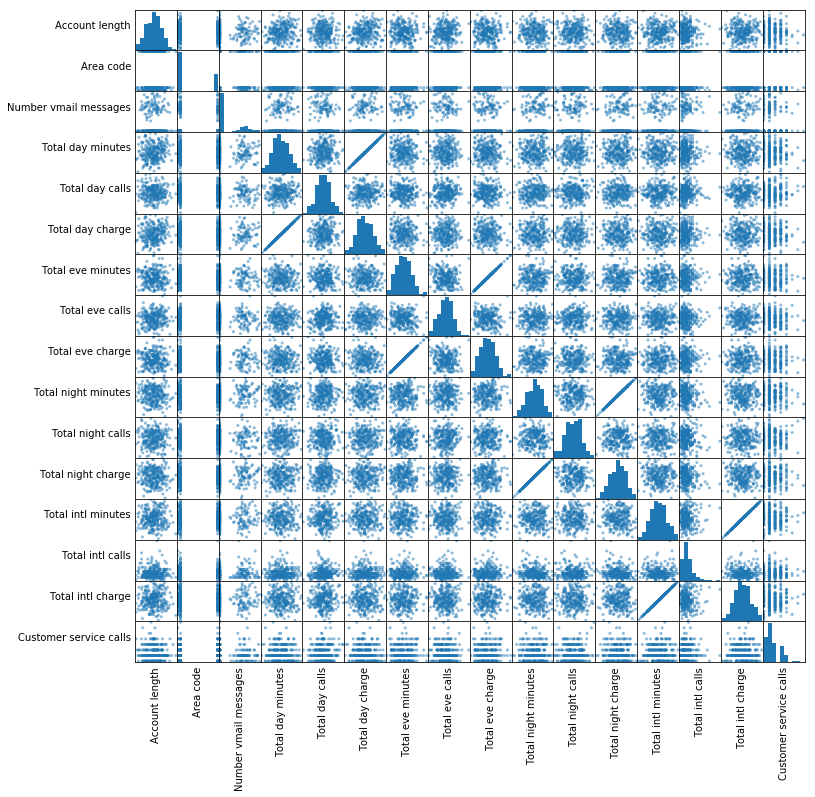

In [55]:
axs = pd.scatter_matrix(sampled_data, figsize=(12, 12))
n = len(sampled_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

In [12]:
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import UserDefinedFunction

CV_data = CV_data.drop("State").drop("Area code") \
                       .drop("Total day charge").drop("Total eve charge") \
                       .drop("Total night charge").drop("Total intl charge") \
                       .withColumn("Churn",
                                   CV_data["Churn"].cast(DoubleType())) \
                       .withColumn("International plan",
                                   CV_data["International plan"]
                                   .cast("boolean").cast(DoubleType())) \
                       .withColumn("Voice mail plan",
                                   CV_data["Voice mail plan"]
                                   .cast("boolean").cast(DoubleType()))
test_data = test_data.drop("State").drop("Area code") \
                       .drop("Total day charge").drop("Total eve charge") \
                       .drop("Total night charge").drop("Total intl charge") \
                       .withColumn("Churn",
                                   test_data["Churn"].cast(DoubleType())) \
                       .withColumn("International plan",
                                   test_data["International plan"]
                                   .cast("boolean").cast(DoubleType())) \
                       .withColumn("Voice mail plan",
                                   test_data["Voice mail plan"]
                                   .cast("boolean").cast(DoubleType()))

In [13]:
pd.DataFrame(CV_data.take(5), columns = CV_data.columns).transpose()

,0,1,2,3,4
Account length,128.0,107.0,137.0,84.0,75.0
International plan,0.0,0.0,0.0,1.0,1.0
Voice mail plan,1.0,1.0,0.0,0.0,0.0
Number vmail messages,25.0,26.0,0.0,0.0,0.0
Total day minutes,265.1,161.6,243.4,299.4,166.7
Total day calls,110.0,123.0,114.0,71.0,113.0
Total eve minutes,197.4,195.5,121.2,61.9,148.3
Total eve calls,99.0,103.0,110.0,88.0,122.0
Total night minutes,244.7,254.4,162.6,196.9,186.9
Total night calls,91.0,103.0,104.0,89.0,121.0


In [14]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [16]:
vecAssembler = VectorAssembler(inputCols = ['Account length', 'International plan', 'Voice mail plan', 'Number vmail messages', 
                                           'Total day minutes', 'Total day calls', 'Total eve minutes', 'Total eve calls', 
                                          'Total night minutes', 'Total night calls', 'Total intl minutes', 'Total intl calls', 
                                          'Customer service calls'], outputCol = 'features')

In [17]:
df_train = vecAssembler.transform(CV_data)

In [19]:
pd.DataFrame(df_train.take(5), columns = df_train.columns).transpose()

,0,1,2,3,4
Account length,128,107,137,84,75
International plan,0,0,0,1,1
Voice mail plan,1,1,0,0,0
Number vmail messages,25,26,0,0,0
Total day minutes,265.1,161.6,243.4,299.4,166.7
Total day calls,110,123,114,71,113
Total eve minutes,197.4,195.5,121.2,61.9,148.3
Total eve calls,99,103,110,88,122
Total night minutes,244.7,254.4,162.6,196.9,186.9
Total night calls,91,103,104,89,121


In [26]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(labelCol = 'Churn', featuresCol = 'features')

In [27]:
pipeline = Pipeline(stages=[vecAssembler, dt])

In [28]:
model = pipeline.fit(CV_data)

In [29]:
predictions = model.transform(test_data)

In [30]:
predictions.select('prediction', 'Churn', 'features').toPandas().head(20)

,prediction,Churn,features
0,0.0,0.0,"[117.0, 0.0, 0.0, 0.0, 184.5, 97.0, 351.6, 80...."
1,1.0,1.0,"[65.0, 0.0, 0.0, 0.0, 129.1, 137.0, 228.5, 83...."
2,1.0,1.0,"[161.0, 0.0, 0.0, 0.0, 332.9, 67.0, 317.8, 97...."
3,0.0,0.0,"[111.0, 0.0, 0.0, 0.0, 110.4, 103.0, 137.3, 10..."
4,0.0,0.0,"[49.0, 0.0, 0.0, 0.0, 119.3, 117.0, 215.1, 109..."
5,0.0,0.0,"[36.0, 0.0, 1.0, 30.0, 146.3, 128.0, 162.5, 80..."
6,0.0,0.0,"[65.0, 0.0, 0.0, 0.0, 211.3, 120.0, 162.6, 122..."
7,0.0,1.0,"[119.0, 0.0, 0.0, 0.0, 159.1, 114.0, 231.3, 11..."
8,0.0,0.0,"[10.0, 0.0, 0.0, 0.0, 186.1, 112.0, 190.2, 66...."
9,0.0,0.0,"[68.0, 0.0, 0.0, 0.0, 148.8, 70.0, 246.5, 164...."


In [31]:
evaluator = BinaryClassificationEvaluator(labelCol = 'Churn', rawPredictionCol='prediction')

In [32]:
evaluator.evaluate(predictions)

0.8184302539565699

In [33]:
paramGrid = ParamGridBuilder().addGrid(dt.maxDepth, [2,3,4,5,6,7]).build()

# Set up 3-fold cross validation
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator, 
                          numFolds=3)

CV_model = crossval.fit(CV_data)

In [34]:
tree_model = CV_model.bestModel.stages[1]
print(tree_model)

DecisionTreeClassificationModel (uid=DecisionTreeClassifier_4079b20c8ab5bbf8dad8) of depth 6 with 89 nodes


In [35]:
predictions_improved = CV_model.bestModel.transform(test_data)

In [36]:
predictions_improved.select('prediction', 'Churn', 'features').toPandas().head(20)

,prediction,Churn,features
0,0.0,0.0,"[117.0, 0.0, 0.0, 0.0, 184.5, 97.0, 351.6, 80...."
1,1.0,1.0,"[65.0, 0.0, 0.0, 0.0, 129.1, 137.0, 228.5, 83...."
2,1.0,1.0,"[161.0, 0.0, 0.0, 0.0, 332.9, 67.0, 317.8, 97...."
3,0.0,0.0,"[111.0, 0.0, 0.0, 0.0, 110.4, 103.0, 137.3, 10..."
4,0.0,0.0,"[49.0, 0.0, 0.0, 0.0, 119.3, 117.0, 215.1, 109..."
5,0.0,0.0,"[36.0, 0.0, 1.0, 30.0, 146.3, 128.0, 162.5, 80..."
6,0.0,0.0,"[65.0, 0.0, 0.0, 0.0, 211.3, 120.0, 162.6, 122..."
7,0.0,1.0,"[119.0, 0.0, 0.0, 0.0, 159.1, 114.0, 231.3, 11..."
8,0.0,0.0,"[10.0, 0.0, 0.0, 0.0, 186.1, 112.0, 190.2, 66...."
9,0.0,0.0,"[68.0, 0.0, 0.0, 0.0, 148.8, 70.0, 246.5, 164...."


In [37]:
evaluator.evaluate(predictions_improved)

0.8640688259109311